**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Keep up the good work on the next sprint! 

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

Let us import the necessary packages and modules for the project. 

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re

from sklearn.dummy import DummyClassifier

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
import spacy
import string

from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
import warnings


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

Using pandas let us load the imdb_reviews.tsv into dataframe. Since the file has tab delimiter, we need to specify that while reading into dataframe. We will explore the review entries and the dataframe structure.

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


There are 48000 entries. There are 17 columns and our focus is on the two main columns - review and pos. review is the column holding reviews and pos is the column which hold 1 if the content in the review column is positive or 0 if negative. Our ML algorithm needs review column data for input and pos column data for output to build model for prediction.

There are 47331 entries in all columns except average_rating and votes column that has missing entries. We will replace the missing entries and also check for duplicate entries and remove them if there are any.

In [7]:
df_reviews[df_reviews['average_rating'].isnull()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


We can replace average_rating and votes with mean values in the respective columns.

In [8]:
df_reviews.loc[df_reviews['average_rating'].isnull(), 'average_rating'] = df_reviews['average_rating'].mean().round(1)
df_reviews.loc[df_reviews['votes'].isnull(), 'votes'] = df_reviews['votes'].mean().round()
df_reviews.iloc[[22280, 22281]]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,6.0,25563,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,6.0,25563,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [9]:
# check if there are any null entries 
print("Null entries in IMDB: ", df_reviews.isnull().sum().sum())
# check for duplicates
print("Duplicated entries in IMDB: ", df_reviews.duplicated().sum())


Null entries in IMDB:  0
Duplicated entries in IMDB:  0


Thus there are no null entries and duplicates.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

## EDA

Let's check the number of movies and reviews over years.

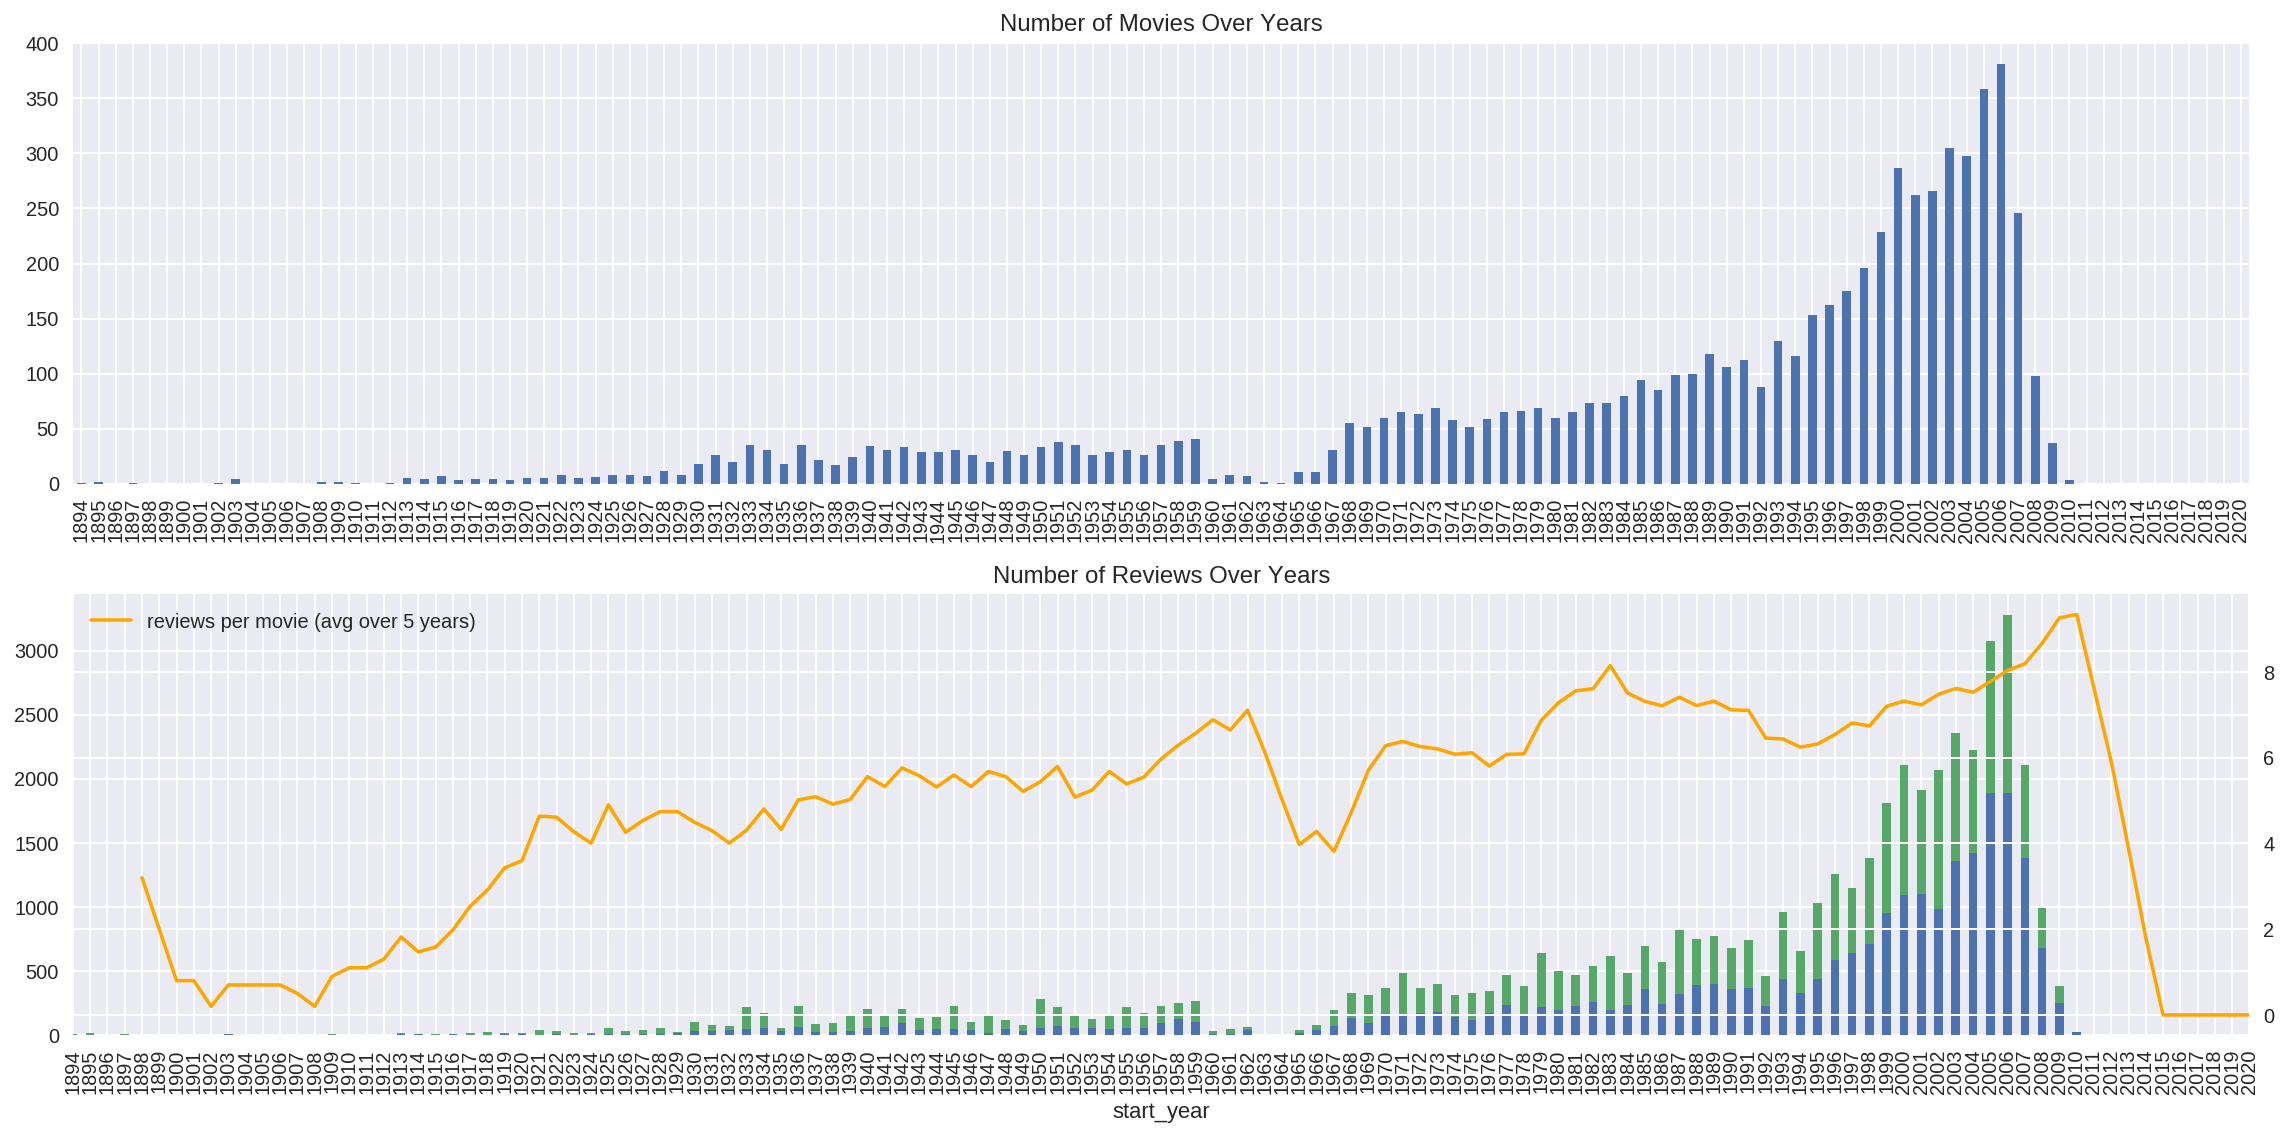

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**Observations and findings**

- Number of movies in the IMDB rose to more than 350 in 2006
- From 1995 onwards there is an upward momentum in the number of movies till 2006. After that the number of movies fell down to less than 50 in 2009
- The rolling average of number of reviews over five years are directly proportional to the number of movies available in IMDB. 2006 has highest number of movies released and correspondingly has the highest number of movie reviews.
- We can sense the positive and negative reviews are kind of balanced for each year's rolling mean. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

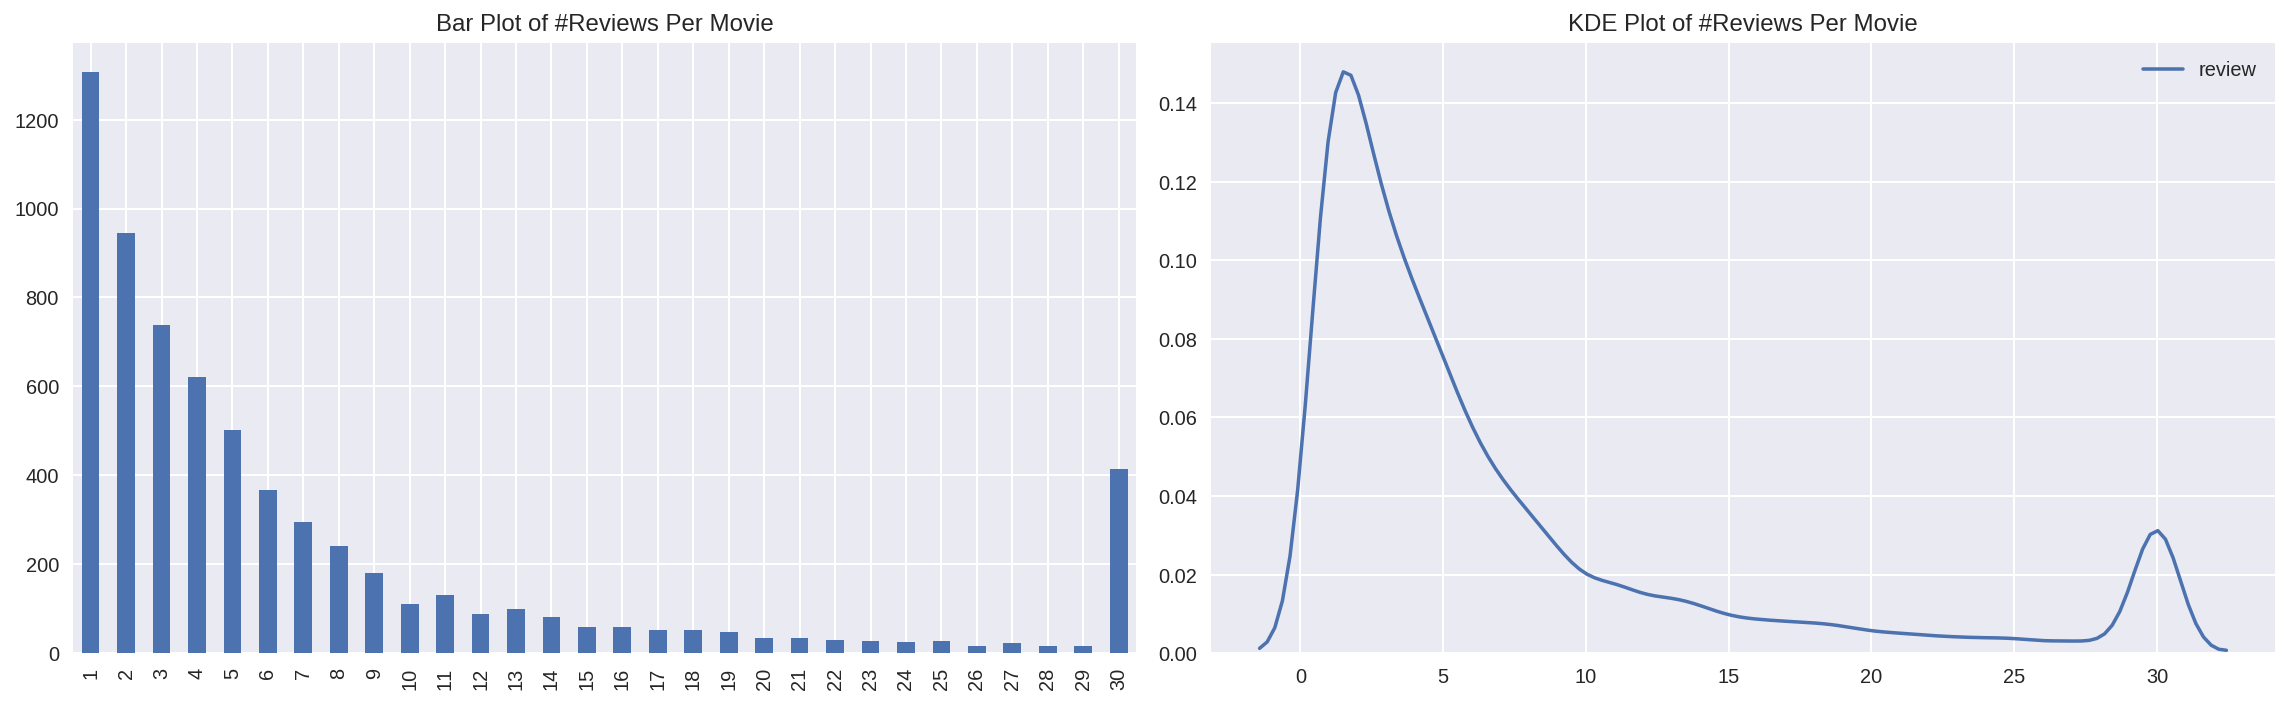

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

More than 1300 movies have only one review. Fewer than 200 movies have 10 or more reviews. The same is reflected in KDE plot. As we can see in the two plots, there is an outlier in the data with 400 movies having 30 reviews. While there is a decline in the number of movies with reviews greater than 10, this sudden increase in number of movies with 30 reviews shows clearly that there is some error in the input data which needs to be further investigated with the team that sourced the data.

Next, we will focus on the distribution of positive and negative reviews and the ratings

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

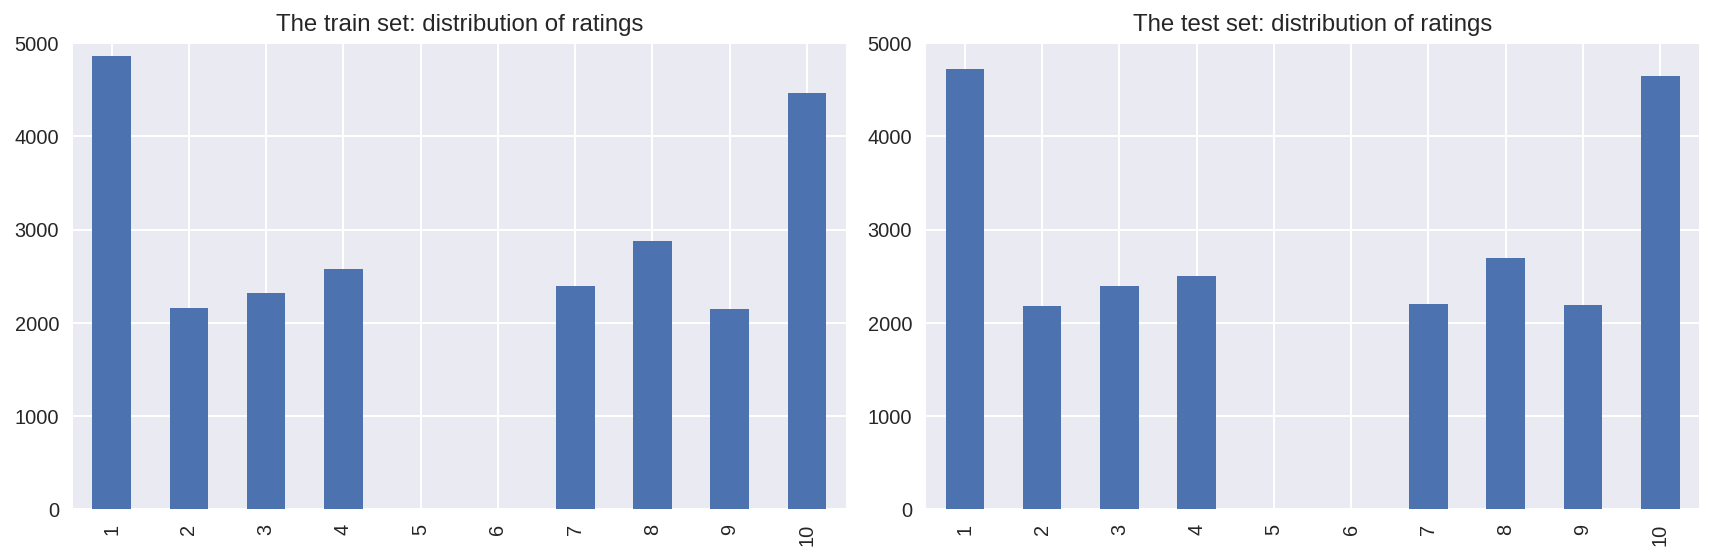

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

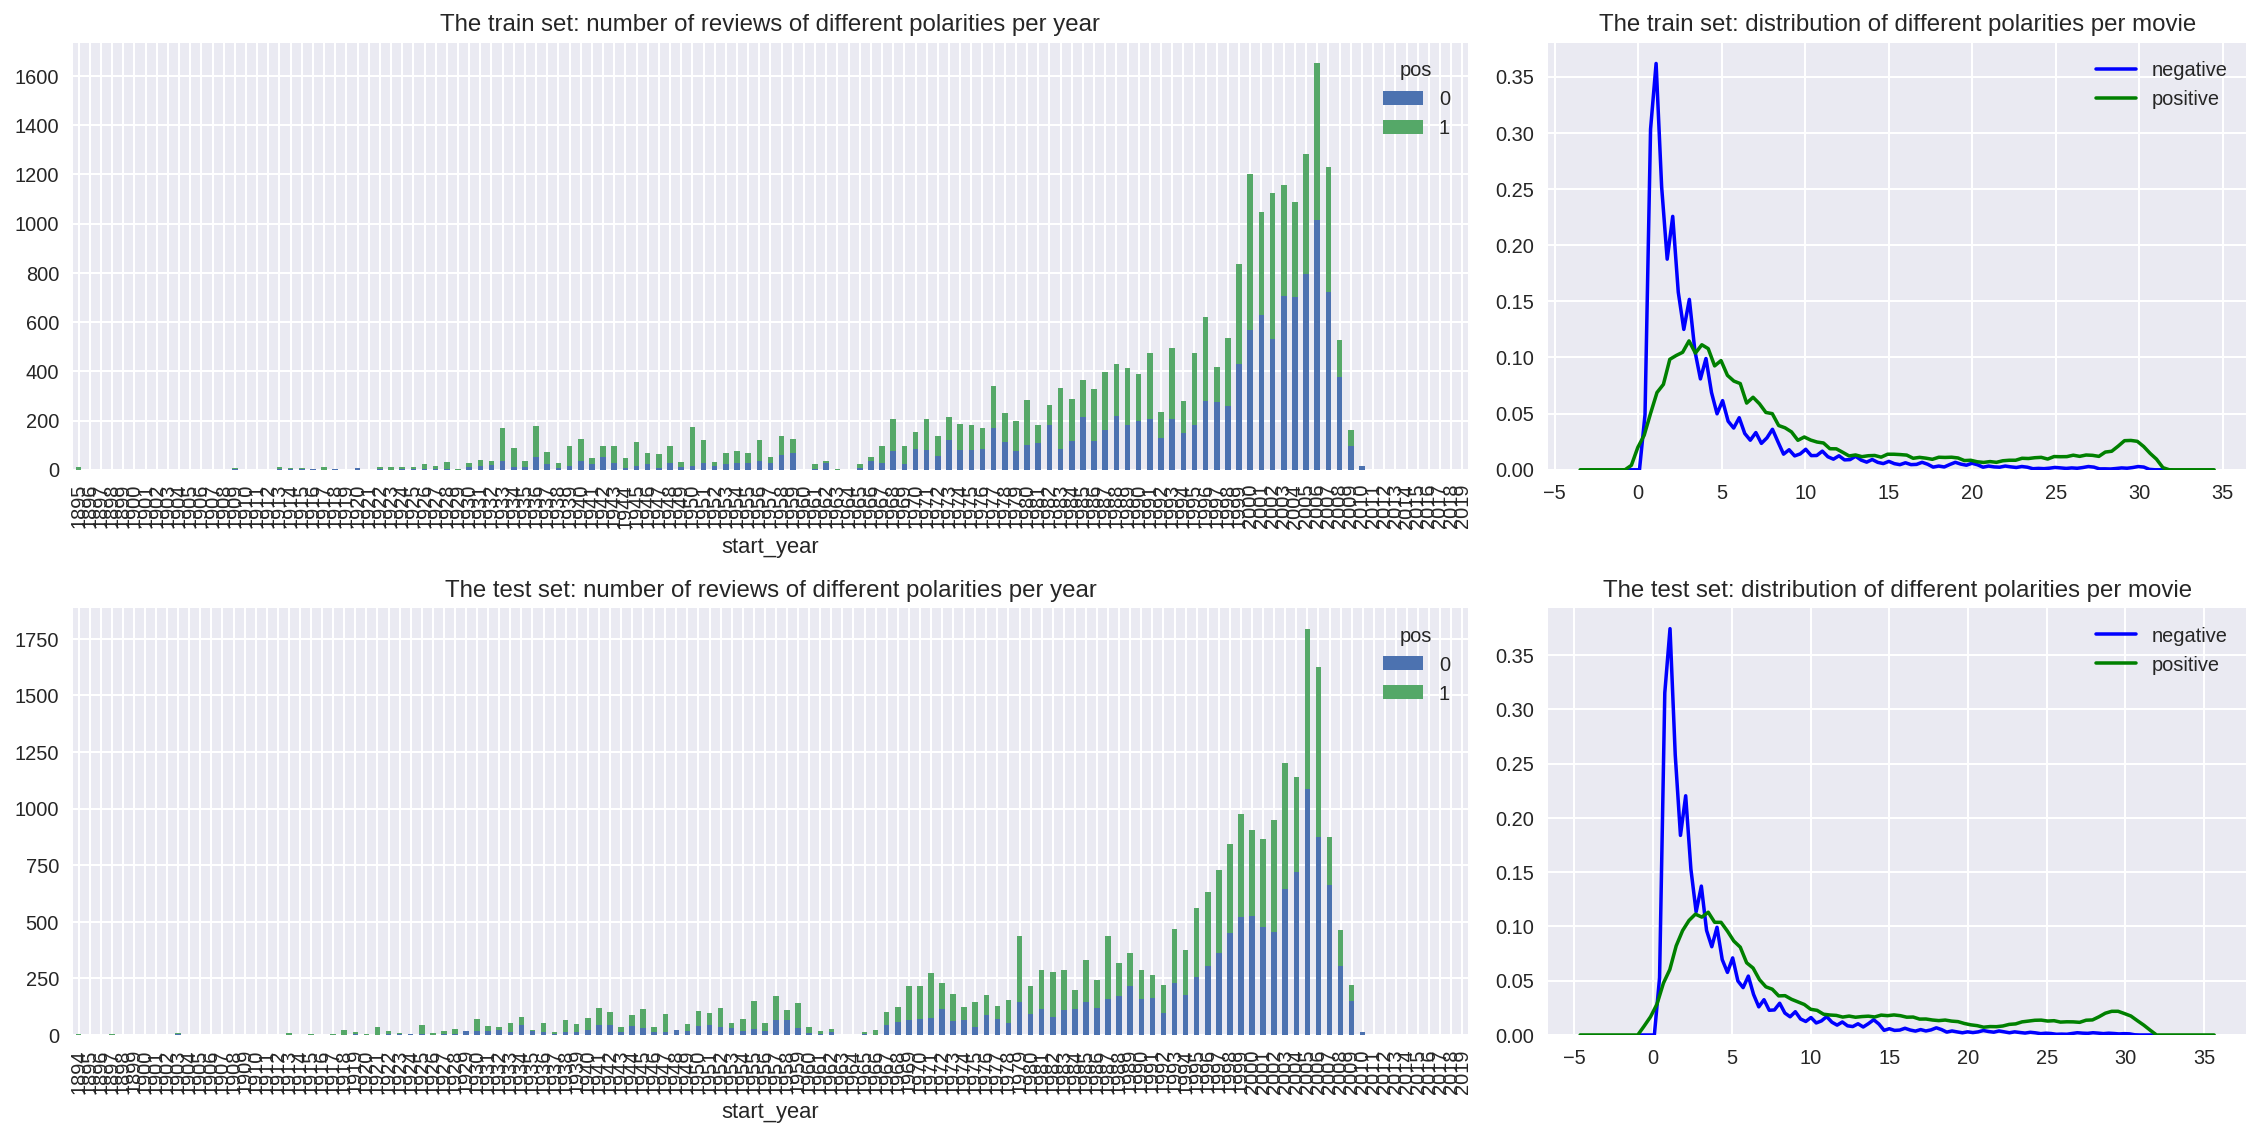

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Observation and findings**

- The distribution of ratings are almost the same in training and test datasets
- The distribution of pos values 0 for negative and 1 positive reviews are even - with 23715 reviews with 0 and 23616 with 1. This clearly shows there is not much imbalance in the classes in the overall dataset.
- The distribution of positive and negative reviews per year among the training set and the test set are similar with left skewed distribution. Thus the test dataset has good sample set of overall population.
- The distribution of the pos values per movie are right skewed and are similar for both training and test dataset

After doing the EDA, it is clear that there is no class imbalance in the target variable pos. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great! You explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:


def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc. For some text with apostraphe symbol, we normalize the text by decontracting some specific and generic phrases. 

In [16]:
'''
    function to decontract the below specific phrases 
    won't    - will not
    can't    - can not
    ain't    - am not
    ma'am    - madam
    you'll   - you all
    'til     - until
    sha'n't/ shan't - shall not
    
    decontract the below general phrases
    n't - not
    're  - are
    'd   - would
    'll  - will
    't   - not
    've  - have
    'm   - am
    
    
'''
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t(?=$|\s)", "will not", phrase)
    phrase = re.sub(r"can\'t(?=$|\s)", "can not", phrase)
    phrase = re.sub(r"ain\'t(?=$|\s)", "am not", phrase)
    phrase = re.sub(r"sha[\']?n\'t(?=$|\s)", "shall not", phrase)
    phrase = re.sub(r"ma\'am(?=$|\s)", "madam", phrase)
    phrase = re.sub(r"y(ou)?\'ll(?=$|\s)", "you all", phrase)
    phrase = re.sub(r"\'til(?=$|\s)", "until", phrase)

    
    # general
    phrase = re.sub(r"n\'t(?=$|\s)", " not", phrase)
    phrase = re.sub(r"\'re(?=$|\s)", " are", phrase)
    phrase = re.sub(r"\'d(?=$|\s)", " would", phrase)
    phrase = re.sub(r"\'ll(?=$|\s)", " will", phrase)
    phrase = re.sub(r"\'t(?=$|\s)", " not", phrase)
    phrase = re.sub(r"\'ve(?=$|\s)", " have", phrase)
    phrase = re.sub(r"\'m(?=$|\s)", " am", phrase)
    phrase = re.sub(r"\'s(?=$|\s)", " is", phrase)
    return phrase

In [17]:
'''
    Function to normalize input text by converting them to lowercasae and remove digits and punctuation marks
    except some apostraphe - which can be decontracted to a meaningful word.
'''
def normalize(text):
    text = decontracted(text.lower())
    text = re.sub(r"[^a-z\s]","", text)
    return text

In [18]:
# normalize the text in reviews
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)
# glimpse on how the text is normalized 
display(df_reviews[['review_norm', 'review']].head(30))

,review_norm,review
0,the pakage implies that warren beatty and gold...,The pakage implies that Warren Beatty and Gold...
1,how the hell did they get this made presenting...,How the hell did they get this made?! Presenti...
2,there is no real story the film seems more lik...,There is no real story the film seems more lik...
3,um a serious film about troubled teens in sin...,Um .... a serious film about troubled teens in...
4,i am totally agree with garryjohal from singap...,I'm totally agree with GarryJohal from Singapo...
5,this is the first movie i have seen from singa...,This is the first movie I've seen from Singapo...
6,yes nonsingaporean is can not see what is the ...,Yes non-Singaporean's can't see what's the big...
7,this true story of carlson is raiders is more ...,This true story of Carlson's Raiders is more o...
8,should have been titled balderdash little in t...,Should have been titled 'Balderdash!' Little i...
9,the movie gung ho the story of carlson is maki...,The movie 'Gung Ho!': The Story of Carlson's M...


### conclusion

- From the above sample, it is clear that the reviews are normalized by
    - changing text to lowercase
    - removing digits and punctuation marks  
    - decontracting some of the text replacing apostraphe

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy().reset_index(drop=True)
df_reviews_test = df_reviews.query('ds_part == "test"').copy().reset_index(drop=True)

train_target = df_reviews_train['pos'].reset_index(drop=True)
test_target = df_reviews_test['pos'].reset_index(drop=True)

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


### Conclusion

- The number of entries in Training set did not differ much to that of test dataset

## Working with models

We have normalized the data and split them into training and test datasets. Next is to build the models with the datasets to classify the positive and negative reviews. Let us build the below models and evaluate them.

- Dummy classifier
- Logistic Regression model with NLTK and TF-IDF Vectorizer
- Logistic Regression model with Spacy and TF-IDF Vectorizer
- Light BGM Classifier model with Spacy and TF-IDF Vectorizer

### Model 0 - Constant

First let us build a dummy model using DummyClassifer with default strategy as "prior" whose predict method always returns the most frequent class label in the observed y argument passed to fit. 

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


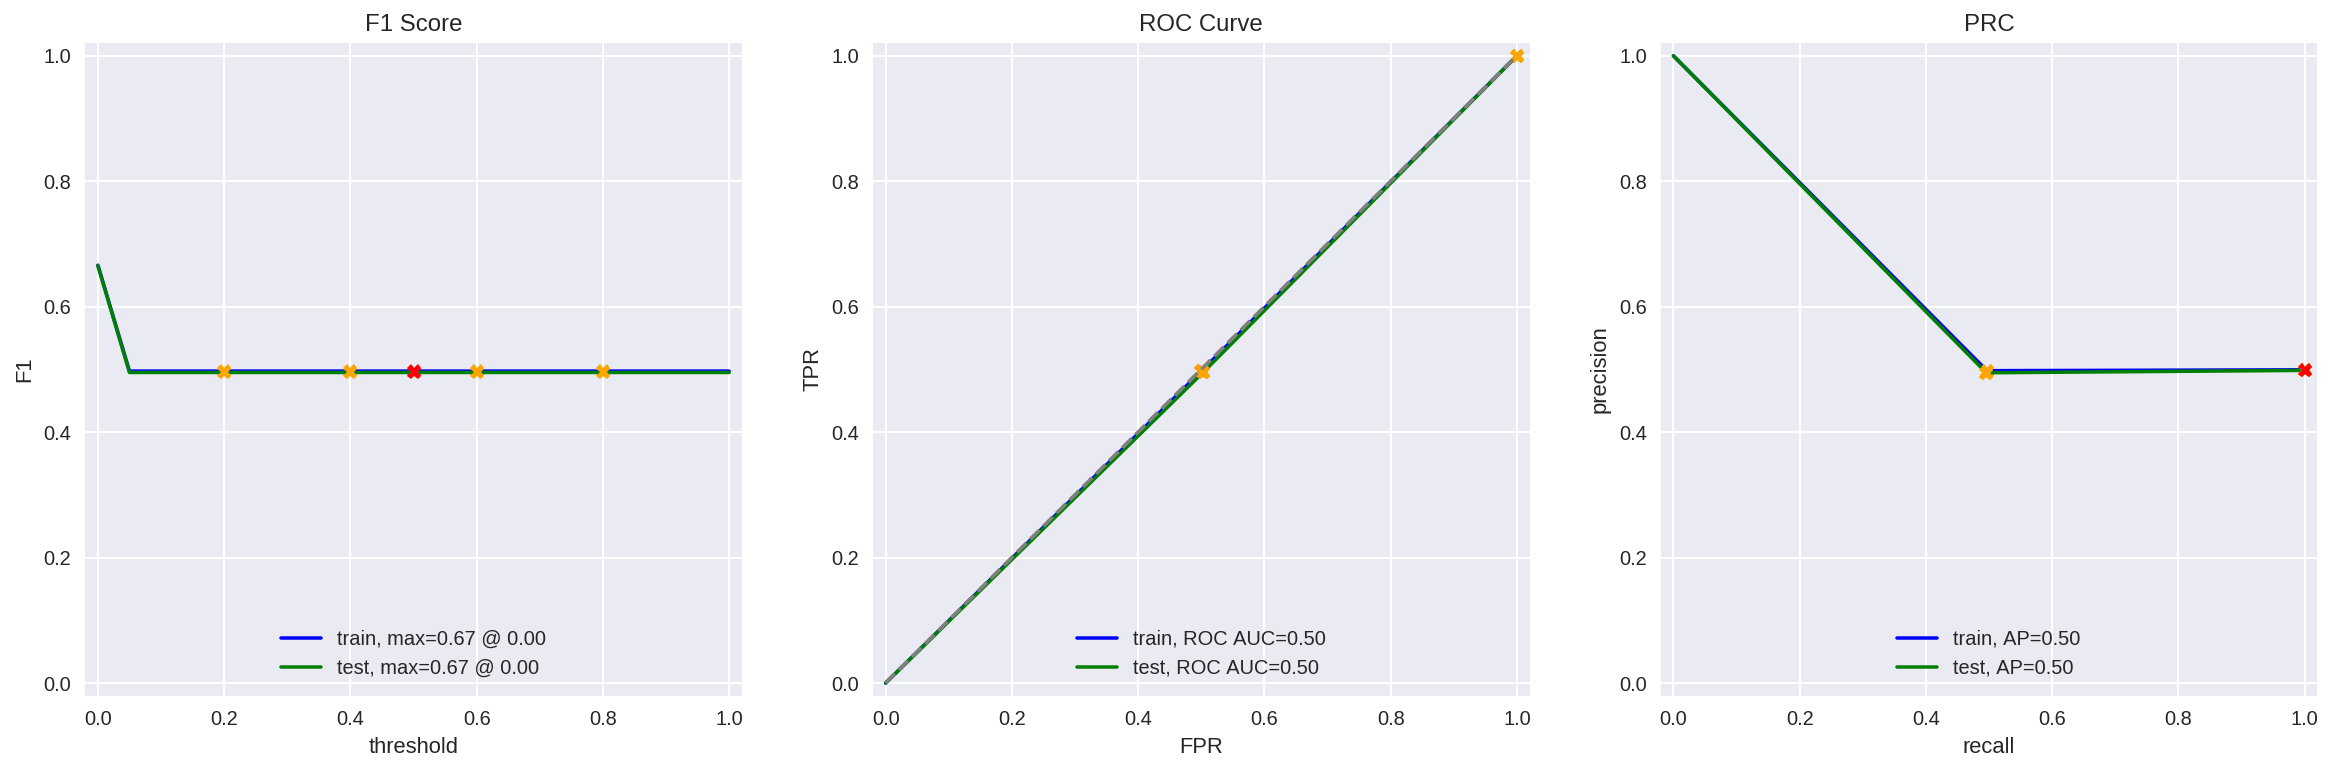

In [20]:
dummy_clf = DummyClassifier()
dummy_clf.fit(df_reviews_train['review_norm'], train_target)
evaluate_model(dummy_clf, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

#### conclusions

- The accuracy and F1 score both are very low with 0.51 as score
- The scores clearly proves what we found during EDA - There are no imbalance of classes in the train and test datasets 
- The dummy classifier fails to qualify as our prediction model with F1 score below 0.85

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good to have a simple baseline!

</div>

### Model 1 - NLTK, TF-IDF and Logistic Regression

Next let us build a model using Logistic Regression. The classify the text first we need to lemmatize the input text. For this we will use NLTK. Using NLTK we can exclude stop words in the text. After that we will use TfidVectorizer to fit the training data. Based on this vector the text in training and test dataset are transformed and stored separately.

The vector transformed training text is fed to the Logistic regression model for training. It is then evaluated using test dataset whose features are also transformed using TfidVectorizer.

In [21]:
stop_words = set(stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stop_words) 

In [22]:
tf_idf.fit(df_reviews_train['review_norm'])
train_td_idf = tf_idf.transform(df_reviews_train['review_norm'])
test_td_idf = tf_idf.transform(df_reviews_test['review_norm'])
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(train_td_idf, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


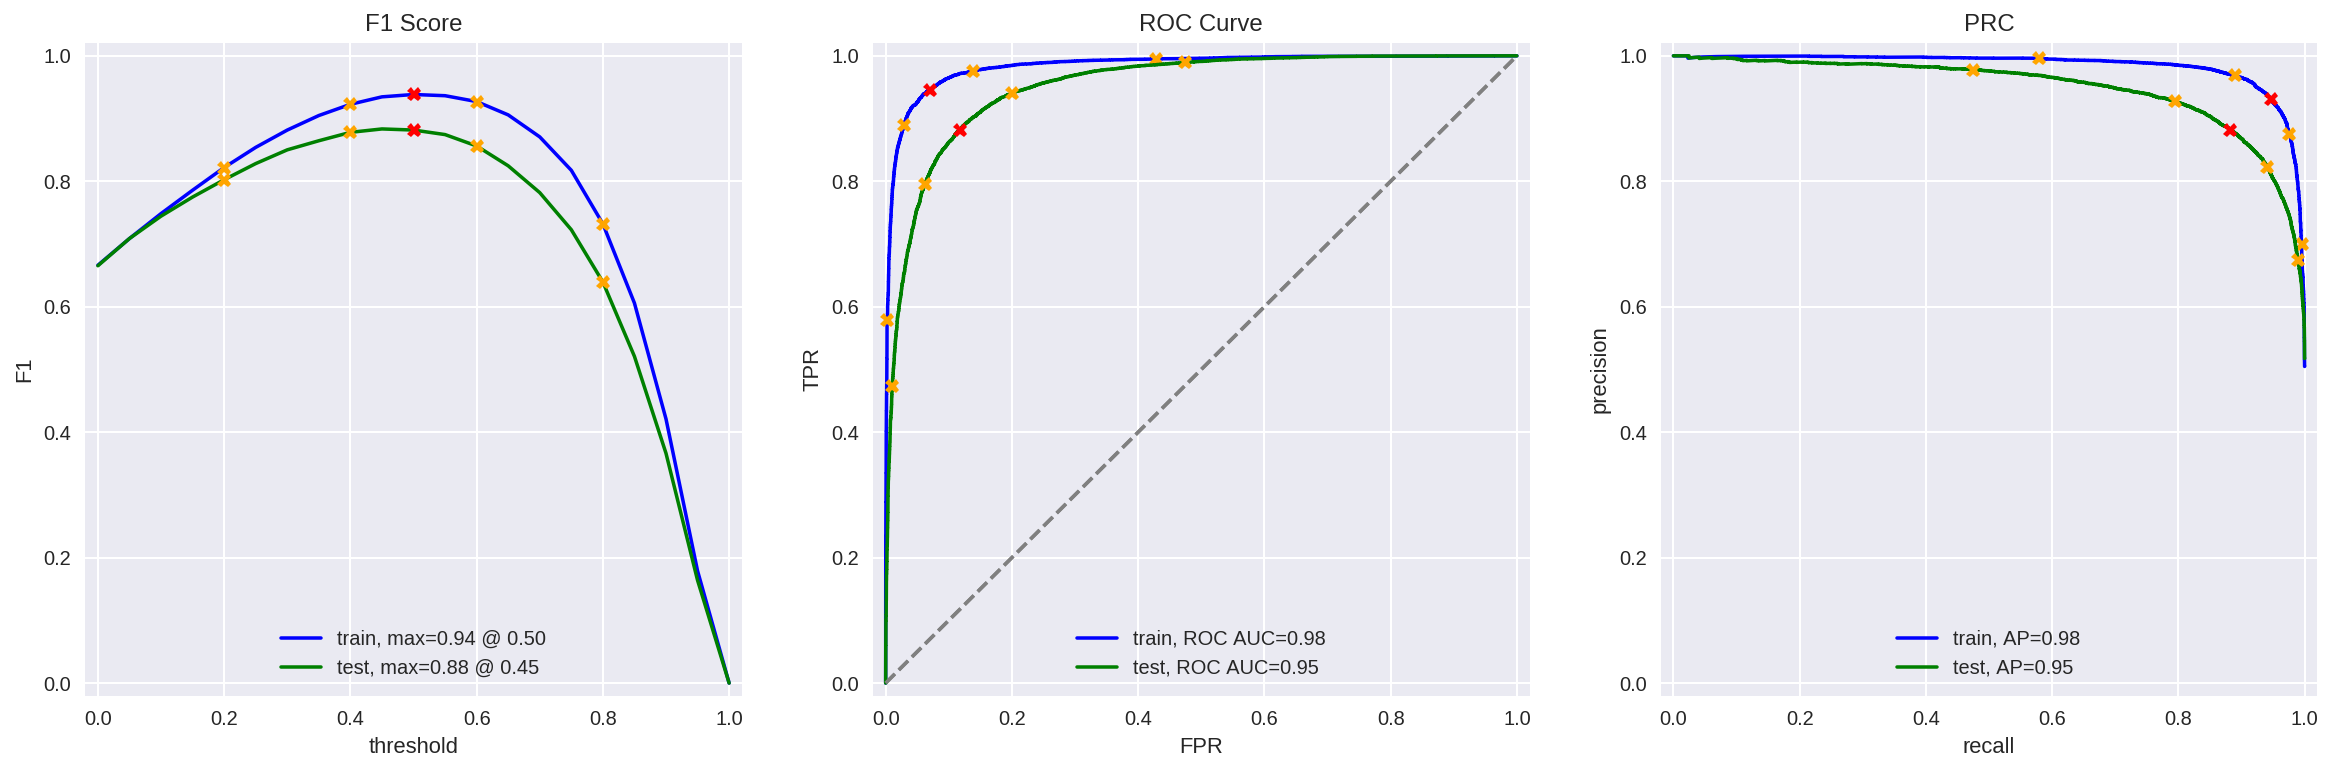

In [23]:
evaluate_model(model_1, train_td_idf, train_target, test_td_idf, test_target)

#### Conclusion

- High scores of Accuracy and F1 for both training and test dataset
- Both training and test datasets have F1 scores above the threshold of 0.85
- A simple Logistic Regression model itself gives best F1 scores and can be considered as prediction model

<div class="alert alert-success">
<b>Reviewer's comment</b>

You successfully used TF-IDF to vectorize the text data and trained a model using the resulting features

</div>

### Model 2 - spaCy, TF-IDF and Logistic Regression

Now instead of NLTK let us spaCy for tokenization process and evaluate the LR model.

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
'''
function to preprocess input text by excluding stop words

'''

def text_preprocessing(text):    
    doc = nlp(text)
    tokens = [word.lemma_ for word in doc if not word.is_stop]
    return " ".join(tokens)

'''
function to return text as list of tokens

'''

def identity_tokenizer(text):
    return text_preprocessing(text).split()


In [26]:
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer)

In [28]:
# fit the training dataset and based on that transform both training and test dataset features
vectorizer.fit(df_reviews_train['review_norm'])
train_td_idf = vectorizer.transform(df_reviews_train['review_norm'])
test_td_idf = vectorizer.transform(df_reviews_test['review_norm'])

In [29]:
# Logistic regression model
model_2 = LogisticRegression()
model_2.fit(train_td_idf, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


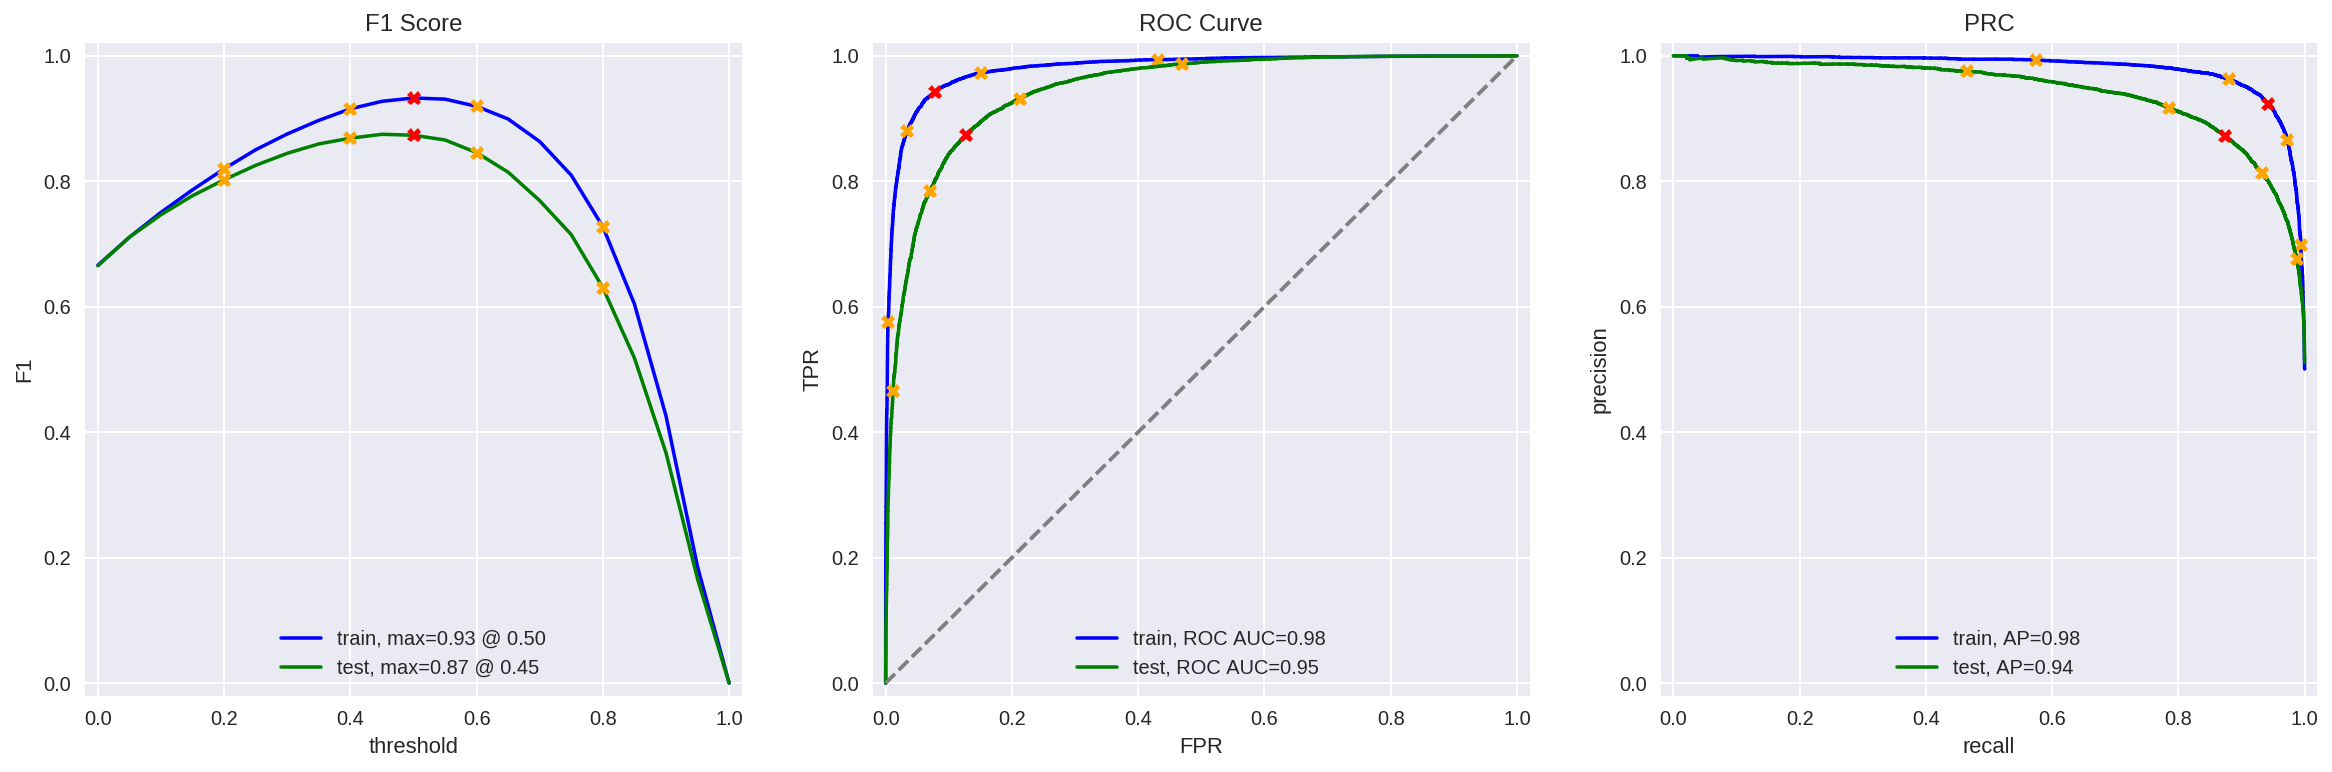

In [30]:
evaluate_model(model_2, train_td_idf, train_target, test_td_idf, test_target)

#### Conclusions

- The metric scores are almost similar to NLTK and TF_IDF based LR model, that is Model 1
- F1 scores for training and test datasets are well above the our threshold 0.85 and qualifies to be considered as prediction model.
- SpaCy and TF-IDF combination makes vectorization process takes more time and is very slow compared to the previous model with NLTK

### Model 4 - spaCy, TF-IDF and LGBMClassifier

Now, by keeping the spaCy and TF-IDF vectorized data, we will just change our training model based on LGBMClassifer algorithm. After training, we will evaluate and visualize the metrics

In [ ]:
model_3 = LGBMClassifier()
model_3.fit(train_td_idf, train_target)

In [ ]:
evaluate_model(model_3, train_td_idf, train_target, test_td_idf, test_target)

#### Conclusion

- The LGBM Classifier model based metrics have also got good F1 and accuracy scores
- F1 score is equal to the threshold 0.85 and hence can be considered as a prediction model
- LGBM model could not produce better  accuracy and F1 scores  than Logistic Regression model

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you also tried lemmatization with spacy!

</div>

## My Reviews

Now let us create our own reviews and test how the different models have their prediction probabilities for classifying them as positive and negative ones. We will take 
- review with prediction probability  <0.5 as negative 
- review with prediction probability >=0.5 as positive 

In [ ]:
# let us evaluate the model with custom reviews

my_reviews = pd.DataFrame([
    'the movie is time waste',
    'I give three out of five stars',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'recommend not to watch this movie'
    'I was really fascinated with the movie',    
    'I did not simply like it, not my kind of movie.',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize) 

my_reviews

### Model 1

For the LR model implemented with NLTK and TF_IDF let us see the prediction probabilities of 10 reviews we added

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

#### conclusion

- If there are explicit negative words, like waste and annoying have got 0 as predicted values.
- The model struggles when the review has implicitly worded meaning - like three out of five stars which means this is not a negative review but it was given 0.3.
- Out of 10 reviews, there should only be 5 negative reviews, but when looking at the model's probabilities as classifying reviews with < 0.5 as negative, we see there are 8 negative reviews - so 3 false negative ones listed below

    - i give three out of five stars
    - the movie has its upsides and downsides but feel like overall it is a decent flick I could see myself going to see it again.
    -  i did not expect the reboot to be so good writers really cared about the source material
- Out of 10 reviews there are only two positive reviews with probability values >=0.5, but actually there are 5 positive reviews which are listed above as false negative.


### Model 2

For the LR model implemented with spaCy and TF_IDF let us see the prediction probabilities of 10 reviews we added

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

#### conclusion

- The probability scores of Model 2 using spaCy are much similar to the previous model based on NLTK- It has the same three false negatives which are actually positive reviews.

### Model 3

Now let us see how the light BGM model predicts our reviews

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

#### conclusion

- With 5 negative reviews LGBM model predicted only 4 negative reviews.
- The below review the model predicted with >0.5 which is a false positive
    - i did not simply like it not my kind of movie - clearly negative one
- The LightBGM model tends to be optimistic and gives false positives while the LR model tends to be pessimistic and give more false negatives.


<div class="alert alert-warning">
<b>Reviewer's comment</b>

The models were applied to custom reviews correctly. Note that it is not appropriate to make any far-reaching conclusions based on these custom reviews. This section is intended for illustration purposes only. If you want to look at the numbers of false positives/false negatives, and so on, please use the test set!

</div>

## Conclusions

To help The Film Junky Union to build a prediction model with F1 score of 0.85 to classify positive and negative reviews in the given IMDB datasets, we imported the required datasets and read them into pandas dataframes. We cleaned the data and then did the exploratory data analysis to find if there are any class imbalance. The reviews had a good mix of positive and negative reviews in both training and test dataset which we found by plotting the distribution of positive and negative reviews.

After EDA, we normalized the text input, by removing digits, punctuation marks. We then split dataset into training and test datasets. Then first we built dummy model for sanity check which always predicts the class that occured most frequently in the training target. With this blind strategy for prediction, we proved that the F1 scores were very much lower than the threshold. 

Then, the Logistic regression Model was trained with datasets that are transformed using NLTK and TF-IDF vectorizer. We evaluated this model with transformed test dataset and found that their F1 scores and accuracy is much higher than the threshold for both training and test datasets. 

We replaced NLTK with spaCy and built another LR model and found that it also yielded the same scores. spaCy based TF-IDF vectorizer took more time to fit and transform the text whereas NLTK took lesser time.

Next, with the same spaCy and TF-IDF vectorizer, we built a gradient boosting based model which is lightBGM and evaluated that model. It yiedled a F1 score equal to the threshold value. Though the scores are great, LR model produced much better results

Finally, we created custom reviews and evaluated the prediction probabilites of each of the above ML models we constructed. We found that LR models are more pessimistic with more false negatives and LGBM models are more optimistic with more false positives in their predictions.

BERT based model has not been implemented in this the project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset.

To conclude, except the dummy classifier model all models we trained and tested produced F1 scores equal to or above threshold values and so we can use any of them to implement Film Junky Union prediction model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions